In [1]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns
from datetime import datetime
from utils.neural_network import train_nn, get_device

from utils.load_data import load_data, load_gt_data
from utils.preprocessing_v2 import Preprocessing, get_gt_diff_logs
from utils.results import bootstrap_ensemble, interactive_plot_predictions, summarize_results
import utils.results as results
import torch
import torch.nn as nn
import os 

TRENDS_FOLDER = 'data/google_trends/'
GDP_FOLDER = 'data/gdp/'
DATA_PREFIX = 'trends_data_by_topic_'

EPS = 1e-15
SEED = 42

os.environ['PATH'] += ':/Users/leonardamsler/bin'
plt.style.use('ieee.mplstyle')

## Loading and Preprocessing Data

### Loading Google Trends

In [2]:
TRAIN_PROPORTION = 0.9
MODE = "pct" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction

In [3]:
data, all_gdps, all_gts = load_data()
data['country'].unique()

array(['Switzerland', 'Germany', 'United Kingdom', 'Japan', 'Canada',
       'Korea', 'United States'], dtype=object)

In [4]:
preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)

X_train, y_train, X_valid, y_valid, x_high_freq = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, 
                                                                  mode="diff", 
                                                                  take_log_diff_gdp=True,
                                                                  gt_trend_removal=False, 
                                                                  keep_pca_components=180, 
                                                                  noisy_data_stds=[0.001, 0.005, 0.01], 
                                                                  add_encoded_month=False, 
                                                                  gt_data_transformations=[get_gt_diff_logs], other_params={'plot_pca': False})

print(all_gts['country'].unique())

X_train shape : (1780, 180)
X_valid shape : (53, 180)
y_train shape : (1780,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)
['Switzerland' 'Germany' 'United Kingdom' 'Japan' 'Canada' 'Korea'
 'United States']


## Simple Prediction Model

Using cuda device


100%|██████████| 100/100 [00:00<00:00, 151.38it/s]


Final training loss: 0.014115593396127224
Final validation loss: 0.4949575662612915
Final validation R^2: 0.34205179199509383
Best r squared: 0.3662377487074966 at epoch 58


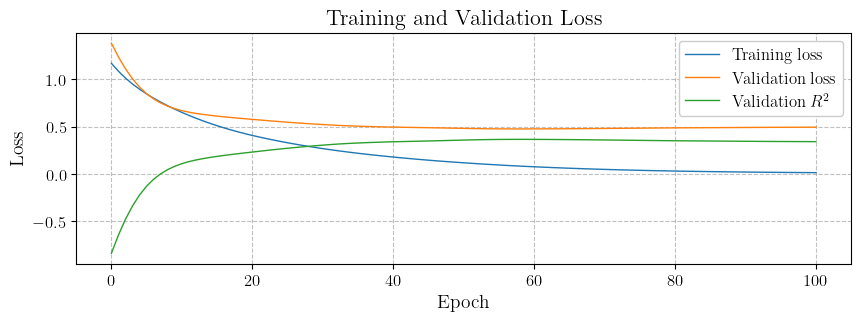

Best R^2: 0.3662377487074966 at epoch 58


In [5]:
model, training_loss, validation_loss, validation_r_squared, mse_losses = train_nn(X_train, 
                                                                       y_train, 
                                                                       X_valid, 
                                                                       y_valid, 
                                                                       num_epochs=100, 
                                                                       learning_rate=1e-4, 
                                                                       weight_decay=1e-2, 
                                                                       verbose=True,
                                                                       seed=SEED)

# Compute best r squared with epoch
best_r_squared = max(validation_r_squared)
best_epoch = validation_r_squared.index(best_r_squared)

print(f"Best R^2: {best_r_squared} at epoch {best_epoch}")

## Ensembling

In [6]:
TRAIN_PROPORTION = 0.9
MODE = "pct" # None | "pct" | "diff"
PERIOD = 4  # Year to year prediction
device = get_device()

In [7]:
data, all_gdps, all_gts = load_data()
data['country'].unique()

array(['Switzerland', 'Germany', 'United Kingdom', 'Japan', 'Canada',
       'Korea', 'United States'], dtype=object)

In [8]:
preprocessor = Preprocessing(epsilon=EPS, gdp_diff_period=PERIOD, all_GDPs=all_gdps, all_GTs=all_gts)

X_train, y_train, X_valid, y_valid, x_hf = preprocessor.preprocess_data(train_pct=TRAIN_PROPORTION, 
                                                                  mode="diff", 
                                                                  take_log_diff_gdp=True,
                                                                  gt_trend_removal=False, 
                                                                  keep_pca_components=180, 
                                                                  noisy_data_stds=[0.005, 0.05, 0.1], 
                                                                  add_encoded_month=False, 
                                                                  gt_data_transformations=[get_gt_diff_logs], other_params={'plot_pca': False})

x_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
x_valid_t = torch.tensor(X_valid, dtype=torch.float32).to(device)
y_valid_t = torch.tensor(y_valid, dtype=torch.float32).to(device)
x_hf_t = torch.tensor(x_hf, dtype=torch.float32).to(device)

print(all_gts['country'].unique())

X_train shape : (1780, 180)
X_valid shape : (53, 180)
y_train shape : (1780,)
y_valid shape : (53,)
X_high_freq shape : (1547, 180)
['Switzerland' 'Germany' 'United Kingdom' 'Japan' 'Canada' 'Korea'
 'United States']


In [9]:
train_fn = lambda seed: train_nn(X_train, y_train, X_valid, y_valid, num_epochs=100, learning_rate=1e-4, weight_decay=1e-2, verbose=False, seed=seed)

x_train_df = {
    'date': preprocessor.dates_high_freq,
    'country': preprocessor.country_high_freq,
    'data': x_hf_t.clone().detach().cpu().numpy().squeeze(),
}


bootstrapped_results = bootstrap_ensemble(X_valid, y_valid, train_fn, n_ensembling=500, seed=SEED, device=get_device(False), other_pred_set=x_train_df)

best_model = bootstrapped_results['best_model']
y_pred_best = bootstrapped_results['y_pred_best']
y_pred_mean = bootstrapped_results['y_pred_mean']
y_pred_std = bootstrapped_results['y_pred_std']
y_pred_median = bootstrapped_results['y_pred_median']
best_rsquared = bootstrapped_results['best_rsquared']
mse_ensemble = bootstrapped_results['mse_ensemble']
rsquared_ensemble = bootstrapped_results['rsquared_ensemble']
mape_ensemble = bootstrapped_results['mape_ensemble']
smoothness_ensemble = bootstrapped_results['other_pred_smoothness']
hf_ensembled_preds = bootstrapped_results['other_pred_ensemble']

Bootstrapping Ensembling: 100%|██████████| 500/500 [03:27<00:00,  2.41it/s]


In [10]:
results.measure_smoothness(np.median(hf_ensembled_preds, axis=1), preprocessor.dates_high_freq, preprocessor.country_high_freq)

[0.6804896062997476, 0.5233915062713863, 0.015861212701109254]

Ensemble R2: 0.45155379407779617
Ensemble MSE: 0.41258201129744576
Ensemble MAPE: 166.07438108181753
Ensemble R2: 0.45155379407779617
Ensemble MSE: 0.41258201129744576
Ensemble MAPE: 166.07438108181753


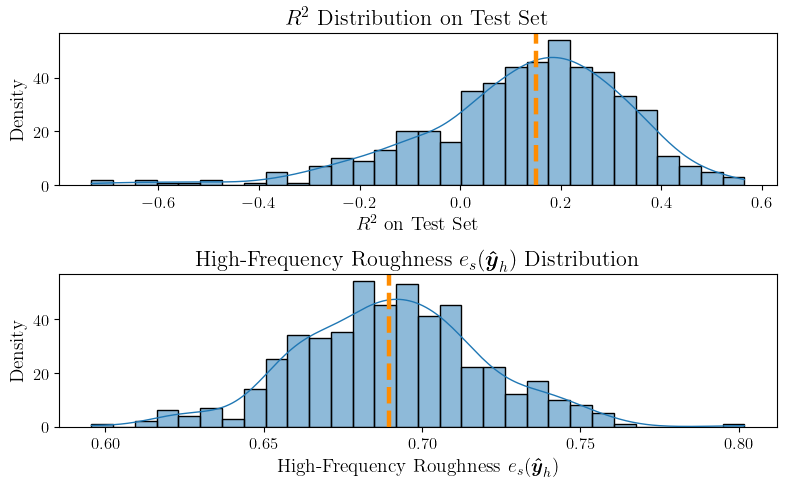

In [11]:
plt.figure(figsize=(8, 5))
plt.subplot(2,1,1)
summarize_results(y_valid, y_pred_mean, rsquared_ensemble, metric_name='$R^2$ Distribution on Test Set', xlabel="$R^2$ on Test Set")
plt.axvline(x=np.median(rsquared_ensemble), color='darkorange', linestyle='--', label='Median $R^2$', linewidth=3.2)
plt.subplot(2,1,2)
# summarize_results(y_valid, y_pred_mean, mape_ensemble, metric_name='MAPE')
# plt.axvline(x=np.median(mape_ensemble), color='darkorange', linestyle='--', label='Median MAPE', linewidth=2)
summarize_results(y_valid, y_pred_mean, smoothness_ensemble, metric_name=r'High-Frequency Roughness $e_s(\boldsymbol{\hat{y}}_h)$ Distribution', xlabel=r"High-Frequency Roughness $e_s(\boldsymbol{\hat{y}}_h)$")
plt.axvline(x=np.median(smoothness_ensemble), color='darkorange', linestyle='--', label='Median $e_s$', linewidth=3.2)
plt.tight_layout()
plt.savefig(results.OUTPUT_DATA_PATH + 'simple_nn_r2_roughness_scores.pdf')
plt.show()

In [12]:
print(f"Median R^2: {np.median(rsquared_ensemble)}")
print(f"Median Smoothness: {np.median(smoothness_ensemble)}")

Median R^2: 0.15122993503383808
Median Smoothness: 0.6895839027110721


In [13]:
plt.rcdefaults()
interactive_plot_predictions(
    country_valid=preprocessor.country_valid,
    y_valid=y_valid,
    y_pred_mean=y_pred_mean,
    y_pred_median=y_pred_median,
    y_pred_best=y_pred_best,
    y_pred_std=y_pred_std,
    title_prefix="GDP Prediction: "
)

interactive(children=(Dropdown(description='selected_country', options=('Canada', 'Germany', 'Japan', 'Korea',…

Using cuda device


100%|██████████| 100/100 [00:00<00:00, 186.29it/s]


Final training loss: 0.01687396503984928
Final validation loss: 0.5011449456214905
Final validation R^2: 0.3338268707359172
Best r squared: 0.3520035127839183 at epoch 58


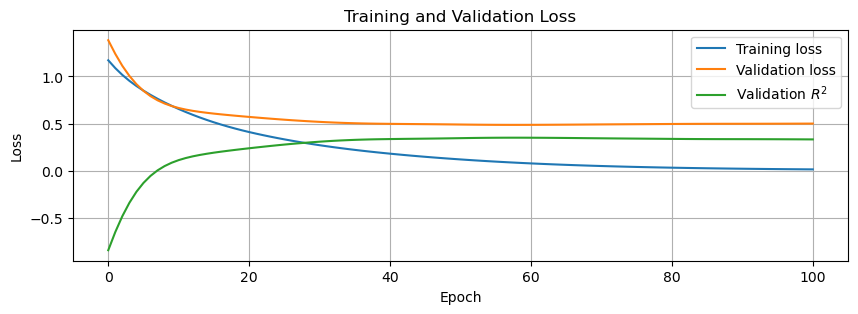

In [14]:
device = get_device(False)

model, training_loss, validation_loss, validation_r_squared, mse_losses = train_nn(X_train, 
                                                                       y_train, 
                                                                       X_valid, 
                                                                       y_valid, 
                                                                       num_epochs=100, 
                                                                       learning_rate=1e-4, 
                                                                       weight_decay=1e-2, 
                                                                       verbose=True,
                                                                       seed=SEED)

# Get the predictions
x_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
x_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_pred = model(x_valid).clone().detach().cpu().numpy().squeeze()
y_pred_train = model(x_train).clone().detach().cpu().numpy().squeeze()

In [15]:
df_preds = pd.DataFrame({
        'date': preprocessor.dates_train,
        'country': preprocessor.country_train,
        'data': [y_pred_train[i] for i in range(len(y_pred_train))]
    })

smoothness_values = []
for country in df_preds['country'].unique():
    country_data = df_preds[df_preds['country'] == country]
    
    smoothness_values_per_func = []
    for smoothness_func in results.all_smoothness_metrics:
        smoothness_values_per_func.append(smoothness_func(country_data['data'].values))

    smoothness_values.append(smoothness_values_per_func)

np.array(smoothness_values_per_func), np.log1p(np.array(smoothness_values_per_func))

(array([0.67272329, 0.45664716, 1.011078  , 0.26841131, 0.61442379,
        0.04525249, 0.65021425, 5.89755093]),
 array([0.51445301, 0.37613733, 0.6986709 , 0.23776518, 0.4789781 ,
        0.04425847, 0.50090513, 1.93116641]))

In [16]:
# Associate the result by country and add 'Set' column
y_pred_country = pd.DataFrame({
    'date': preprocessor.dates_valid,
    'country': preprocessor.country_valid,
    'Single Model Prediction': y_pred,
    'True value': y_valid,
    'Set': 'Validation'
})

y_pred_train_country = pd.DataFrame({
    'date': preprocessor.dates_train,
    'country': preprocessor.country_train,
    'Single Model Prediction': y_pred_train,
    'True value': y_train,
    'Set': 'Training'
})

y_pred_country_ensemble = pd.DataFrame({
    'date': preprocessor.dates_valid,
    'country': preprocessor.country_valid,
    'Ensemble Prediction': y_pred_mean,
    'Single Model Prediction': y_pred,
    'Std': y_pred_std,
    'True value': y_valid,
    'Set': 'Validation'
})

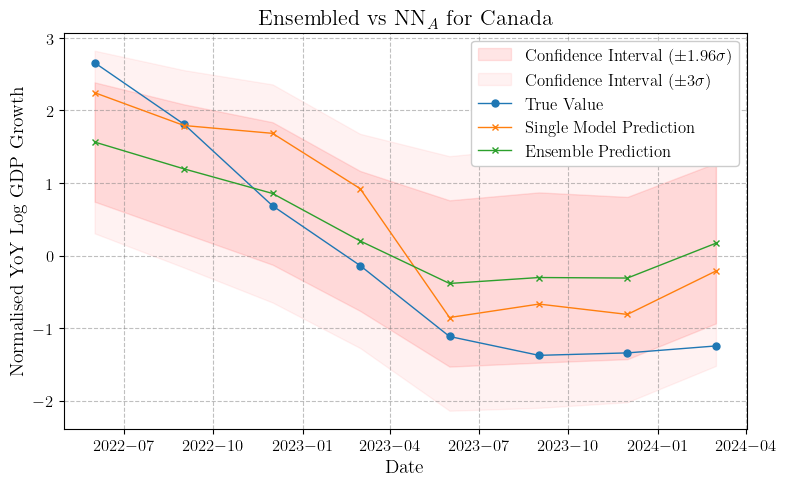

In [17]:
SELECTED_COUNTRY = 'Canada'

plt.style.use('ieee.mplstyle')
filtered_data = y_pred_country_ensemble[y_pred_country_ensemble["country"] == SELECTED_COUNTRY]

plt.figure(figsize=(8, 5))

multiplier1 = 1.96  # ~95% confidence
multiplier2 = 3  # ~99.7% confidence
        
# First confidence interval (e.g., ±3σ)
plt.fill_between(
    filtered_data["date"],
    filtered_data["Ensemble Prediction"] - multiplier1 * filtered_data['Std'],
    filtered_data["Ensemble Prediction"] + multiplier1 * filtered_data['Std'],
    color='red',
    alpha=0.1,
    label=f'Confidence Interval ($\pm {multiplier1}\sigma$)'
)

# Second confidence interval (e.g., ±1.96σ for ~95% confidence)
plt.fill_between(
    filtered_data["date"],
    filtered_data["Ensemble Prediction"] - multiplier2 * filtered_data['Std'],
    filtered_data["Ensemble Prediction"] + multiplier2 * filtered_data['Std'],
    color='red',
    alpha=0.05,
    label=f'Confidence Interval ($\pm {multiplier2}\sigma$)'
)

plt.plot(filtered_data["date"], filtered_data["True value"], label="True Value", marker='o')
plt.plot(filtered_data["date"], filtered_data["Single Model Prediction"], label="Single Model Prediction", marker='x')
plt.plot(filtered_data["date"], filtered_data["Ensemble Prediction"], label="Ensemble Prediction", marker='x') 

plt.title("Ensembled vs $\\text{NN}_A$ for " + SELECTED_COUNTRY)
plt.xlabel("Date")
plt.ylabel("Normalised YoY Log GDP Growth")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig(results.OUTPUT_DATA_PATH + f"{SELECTED_COUNTRY}_low_frequency_predictions.pdf")
plt.show()

plt.rcdefaults()

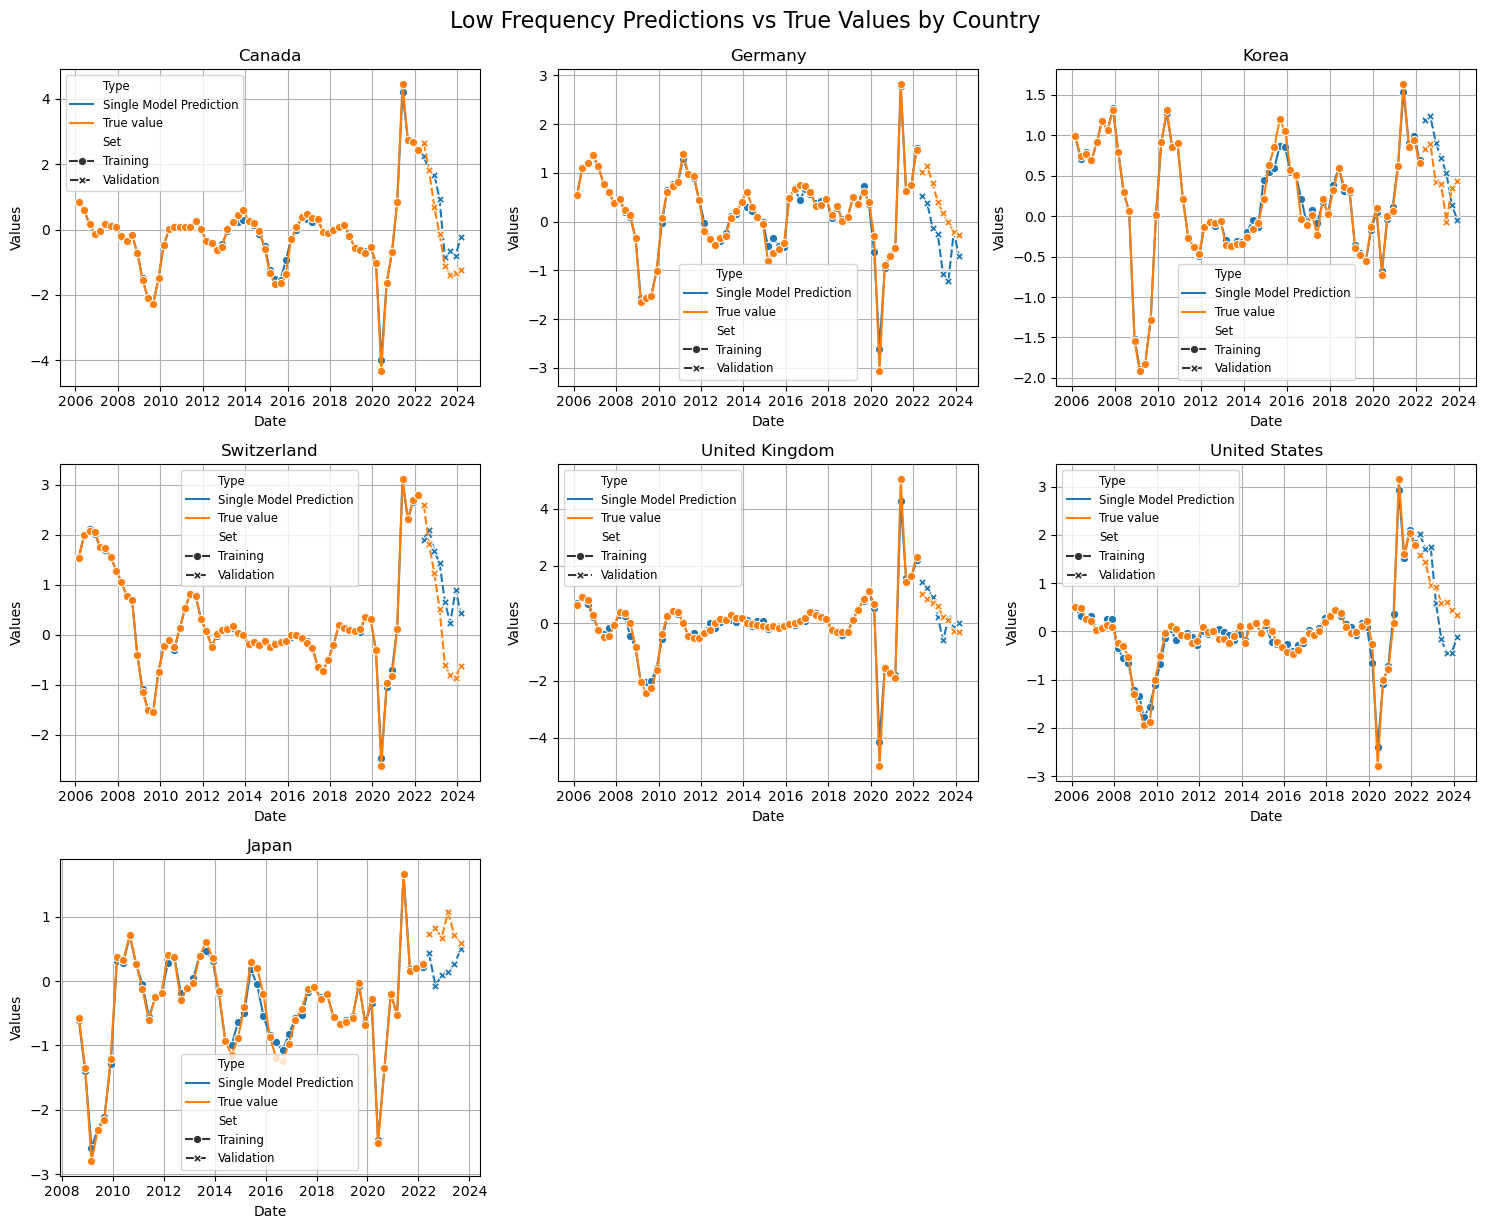

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcdefaults()

# Combine the train and validation set
predictions = pd.concat([y_pred_train_country, y_pred_country])

# Melt the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country", "Set"],
    value_vars=["Single Model Prediction", "True value"], 
    var_name="Type", value_name="Value"
)

# Unique list of countries
countries = predictions["country"].unique()

# Determine grid size for subplots
num_countries = len(countries)
cols = 3  # Number of columns in subplot grid
rows = -(-num_countries // cols)  # Calculate number of rows with ceiling division

# Create the figure and axes for subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through countries and plot data for each
for idx, country in enumerate(countries):
    ax = axes[idx]  # Select subplot axis
    filtered_data = predictions_melted[predictions_melted["country"] == country]
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", style="Set", errorbar=None,
        markers=True, ax=ax
    )
    ax.set_title(f"{country}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Values")
    ax.grid(True)
    ax.legend(loc="best", fontsize="small")

# Remove unused axes (if any)
for i in range(len(countries), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.suptitle("Low Frequency Predictions vs True Values by Country", fontsize=16, y=1.02)
plt.show()


### Paper plot

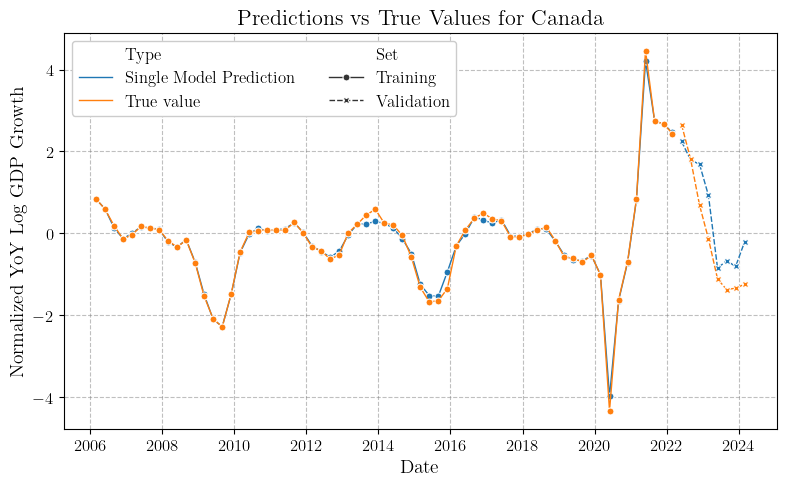

In [19]:
plt.style.use('ieee.mplstyle')

SELECTED_COUNTRY = 'Canada'

filtered_data = predictions_melted[predictions_melted["country"] == SELECTED_COUNTRY]
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=filtered_data,
    x="date", y="Value", hue="Type", errorbar = None, style="Set", markers=True
)
plt.title(f"Predictions vs True Values for {SELECTED_COUNTRY}")
plt.xlabel("Date")
plt.ylabel("Normalized YoY Log GDP Growth")
plt.legend(loc='upper left', ncol=2)
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig(results.OUTPUT_DATA_PATH + f"{SELECTED_COUNTRY}_simple_predictions.pdf")
plt.show()

plt.rcdefaults()

## High frequency predictions

In [20]:
# Predict for the high frequency data
y_pred_high_freq = model(torch.tensor(x_high_freq, dtype=torch.float32).to(device)).cpu().detach().numpy().flatten()
y_pred_high_freq_country = pd.DataFrame({'date': preprocessor.dates_high_freq, 'country': preprocessor.country_high_freq, 'y_pred': y_pred_high_freq})

In [21]:
# Get the true GDPs
country_train = preprocessor.country_train
country_valid = preprocessor.country_valid
all_true_gdps_country = np.concatenate([y_train, y_valid], axis=0)
all_dates = pd.concat([preprocessor.dates_train, preprocessor.dates_valid], axis=0)
all_true_gdps_country = pd.DataFrame({'date': all_dates, 'country': np.concatenate([country_train, country_valid], axis=0), 'y_true': np.concatenate([y_train, y_valid], axis=0)})

In [22]:
# Set the predicions to be plotted
predictions = y_pred_high_freq_country

# Add the true gdp for the points that we have
predictions = predictions.merge(all_true_gdps_country, on=["date", "country"], how="left")

# Remove duplicates
predictions = predictions.drop_duplicates(subset=["date", "country"])

# Rename y_pred to y_pred_high_freq
predictions = predictions.rename(columns={"y_pred": "High Frequency Prediction", "y_true": "True Value"})

In [23]:
# Function to plot data for the selected country
def plot_by_country(selected_country):
    filtered_data = predictions[predictions["country"] == selected_country]
    cutoff_date = predictions['date'].quantile(TRAIN_PROPORTION)
    non_nans = filtered_data["True Value"].notna()
    y_trues = filtered_data["True Value"][non_nans]
    plt.figure(figsize=(15, 5))
    plt.plot(filtered_data["date"], filtered_data["High Frequency Prediction"], label="Predicted")
    plt.plot(filtered_data["date"][non_nans], y_trues, label="True")
    plt.title(f"High frequency predictions vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({TRAIN_PROPORTION}%)')
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
countries.sort()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the plot function
interact(plot_by_country, selected_country=dropdown)

plt.show()

interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Japan', 'Korea', 'Switze…

### Paper plot

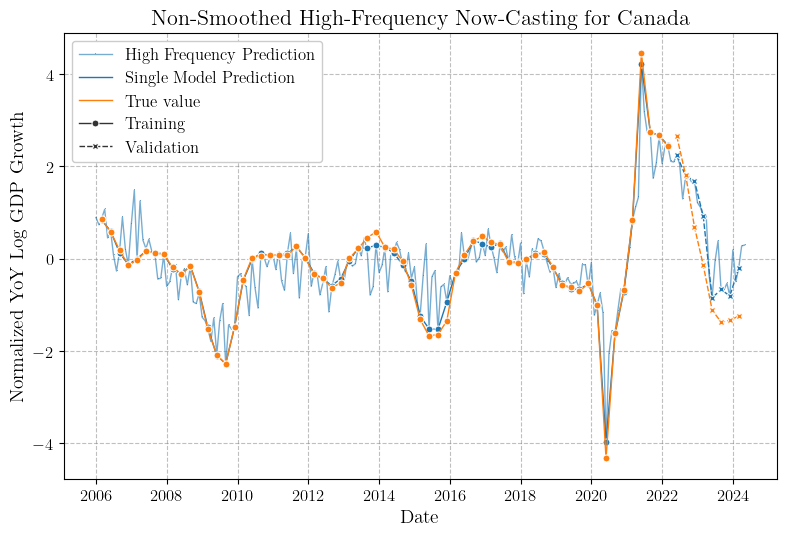

In [24]:
plt.style.use('ieee.mplstyle')
SELECTED_COUNTRY = 'Canada'

filtered_data = predictions_melted[predictions_melted["country"] == SELECTED_COUNTRY]
filtered_hf_data = predictions[predictions["country"] == SELECTED_COUNTRY]

plt.figure(figsize=(8, 5.5))

plt.plot(filtered_hf_data["date"], 
         filtered_hf_data["High Frequency Prediction"], 
         label="High Frequency Prediction", 
         color="#1F77B4",
         linewidth=1,
         marker=',', 
         alpha=0.6)

sns.lineplot(
    data=filtered_data,
    x="date", y="Value", hue="Type", errorbar = None, style="Set", markers=True
)

# Extract current legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Filter out "Type" and "Set"
filtered_handles_labels = [(h, l) for h, l in zip(handles, labels) if l not in ["Type", "Set"]]

# Update the legend
plt.legend(*zip(*filtered_handles_labels), loc='best', ncol=1)

plt.title(f"Non-Smoothed High-Frequency Now-Casting for {SELECTED_COUNTRY}")
plt.xlabel("Date")
plt.ylabel("Normalized YoY Log GDP Growth")
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig(results.OUTPUT_DATA_PATH + f"{SELECTED_COUNTRY}_hf_simple_predictions.pdf")
plt.show()